## Загрузим необходимые библиотеки

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from torch import nn
from torch.optim import lr_scheduler, Adam
from torch.utils.data import Dataset
from tqdm import tqdm
from transformers import DistilBertModel, DistilBertTokenizer
import gc
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas as pd
import re
import torch
import warnings

warnings.filterwarnings('ignore')

## А сюда необходимые нам классы и функции

In [2]:
class MyDataset(Dataset):

    def __init__(self, dataset_type,):
       
        if dataset_type == 'train':
            file = 'ranking_train.jsonl'
        else:
            file = 'ranking_test.jsonl'
        f = open(file, 'r')
        lines = f.readlines()
        f.close()

        
        self.lines = []
        for i in range(len(lines)):
            line = json.loads(lines[i])
            self.lines.append(line)
        print('Количество topics в', dataset_type, ':', len(self.lines))
    
    def __len__(self):
        return len(self.lines)
    
    def __getitem__(self, idx):

        lines = self.lines[idx]

    
        sample = {
            'topic': lines['text'],
            'comments': lines['comments'],
        }
        
        return sample

In [3]:
class My_Model(nn.Module):
    '''
      Класс сети обучения
      на вход принимает: сеть получения эмбеддингов
      на выходе: эмбеддинг якоря и после линейного слоя классификации
    '''
    def __init__(self, EmbeddingNet):
        super(My_Model, self).__init__()
        self.embeddingLayer = EmbeddingNet
        self.classifierLayer = nn.Linear(768, 5)

    def forward(self, topic, topic_attention_mask, comment, comment_attention_mask):
        topic_em = self.embeddingLayer(topic, attention_mask = topic_attention_mask, return_dict=False)
        comment_em = self.embeddingLayer(comment, attention_mask = comment_attention_mask, return_dict=False)
#         print(type(comment_em))
        logits = self.classifierLayer(comment_em[0][:, 0, :])
        return topic_em[0][:, 0, :], comment_em[0][:, 0, :], logits

In [4]:
def custom_loss():
    '''
      Функция получения сводного лосса по модели
      на вход принимает: функцию определения расстояние м/у векторами, значение допуска и обмена
      на выходе: сводный лосс
    '''
    loss1 = nn.CosineEmbeddingLoss()
    loss2 = nn.CrossEntropyLoss()
    def helper(topic, comment, logits, score):
        '''
          Функция лоссов по модели
          на вход принимает: эмбеддинги (якорь, позитивный и негативный) и конечный с линейного слоя
          на выходе: результат сводного лосса
        '''
#         print(loss1(topic, comment) + loss2(logits, score))
        return loss1(topic, comment, score) + loss2(logits, score)
    return helper

In [21]:
def clear_text(text):
    
    text = text.lower()
    
    text = re.sub(r'[^a-zA-Z ]', ' ', text).strip()
    
    # Удаляем html теги
    text = re.sub(r'<[^>]+>', ' ', text)
    
    # Удаляем единичные символы
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Удаляем единычные символы из начала строки
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 
    
    # Заменяем несколько пробелов на один
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    
    # Удаляем 'b'
    text = re.sub(r'^b\s+', '', text)
        
    return text

In [60]:
def train(train_files, val_files, model, epochs, batch_size, optimizer=None, criterion=None, sheduler=None):
    '''
    Функция обучения по эпохам
    принимает на вход: даталоадер с тренировочными данными, даталоадер с проверочными данными ,модель,
    количество эпох обучения, размер батча, оптимайзер, функцию потерь, планировщик
    отдает: лучшую модель на обучении, историю обучения
    '''        
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters()) # будем использовать модель Adam
    if criterion is None:
        criterion = nn.CrossEntropyLoss() # будем использовать кросэнтропию
    
    best_model = model.state_dict() # сохраняем все тензоры модели
    best_acc = 0.0 # для понимания лучшего скора модели
    
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = criterion

        for epoch in range(epochs):
            train_acc, train_loss = fit_epoch(model, train_loader, criterion, opt, sheduler)
            print("loss", train_loss)
            
            val_acc, val_loss = eval_epoch(model, val_loader, criterion)
            history.append((epoch, train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_acc:
                best_acc = val_acc
                best_model = model.state_dict()
                            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
    
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model)
    return model, history

In [61]:
def fit_epoch(model, train_loader, loss_fn, optimizer, sheduler=None):
    '''
    Функция обучения на эпохе
    принимает на вход: модель, даталоадер, функцию потерь, функцию оптимизатора и планировщика
    отдает: масив метрики accuracy, средний лосс по эпохе
    '''
    losses = []

    num_correct = 0
    num_elements = 0
    
    model.train(True) # так как нам необходимо оптимизировать данные на train
    
    for i, batch in enumerate(train_loader):
        tokenized_topic = [tokenizer.encode(
                clear_text(batch[k]['topic']),
                add_special_tokens=True,
                truncation=True,
                max_length=max_len) for k in range(len(batch))]
        padded_topic = np.array([i + [0]*(max_len - len(i)) for i in tokenized_topic])
        topic_attention_mask = np.where(padded_topic != 0, 1, 0)

        tokenized_comments = [tokenizer.encode(
                clear_text(batch[j]['comments'][k]['text']),
                add_special_tokens=True,
                truncation=True,
                max_length=max_len) for j in range(len(batch)) for k in range(len(batch[j]['comments']))]
        padded_comments = np.array([i + [0]*(max_len - len(i)) for i in tokenized_comments])
        comments_attention_mask = np.where(padded_comments != 0, 1, 0)
        score = np.array([
            batch[j]['comments'][k]['score'] for j in range(len(batch)) for k in range(len(batch[j]['comments']))
        ])      
        
        num_elements += score.shape[0]
        optimizer.zero_grad()

        topic, comments, logits = model(
            torch.LongTensor(padded_topic).to(device),
            torch.LongTensor(topic_attention_mask).to(device),
            torch.LongTensor(padded_comments).to(device),
            torch.LongTensor(comments_attention_mask).to(device)
        )



        loss = loss_fn(
            torch.repeat_interleave(topic, CLASS_COUNT, dim=0),
            comments,
            logits,
            torch.LongTensor(score).to(device)
        )

        optimizer.zero_grad()
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        y_pred = torch.argmax(logits, dim=1)
        num_correct += torch.sum(y_pred.cpu() == torch.LongTensor(score))
        
    if sheduler is not None: # проверяем нужна ли нам оптимизация
        sheduler.step() # если да, то делаем шаг оптимизации
    
    accuracy = num_correct / num_elements
    
    return accuracy.numpy(), np.mean(losses)

In [62]:
def eval_epoch(model, dataloader, loss_fn):
    '''
    Функция проверки обучения на эпохе
    принимает на вход: модель, даталоадер, функцию потерь
    отдает: масив метрики accuracy, средний лосс по эпохе
    '''    
    losses = []

    num_correct = 0
    num_elements = 0
    
    model.eval()

    for i, batch in enumerate(dataloader):
        
        tokenized_topic = [tokenizer.encode(
                clear_text(batch[k]['topic']),
                add_special_tokens=True,
                truncation=True,
                max_length=max_len) for k in range(len(batch))]
        padded_topic = np.array([i + [0]*(max_len - len(i)) for i in tokenized_topic])
        topic_attention_mask = np.where(padded_topic != 0, 1, 0)

        tokenized_comments = [tokenizer.encode(
                clear_text(batch[j]['comments'][k]['text']),
                add_special_tokens=True,
                truncation=True,
                max_length=max_len) for j in range(len(batch)) for k in range(len(batch[j]['comments']))]
        padded_comments = np.array([i + [0]*(max_len - len(i)) for i in tokenized_comments])
        comments_attention_mask = np.where(padded_comments != 0, 1, 0)
        score = np.array([
            batch[j]['comments'][k]['score'] for j in range(len(batch)) for k in range(len(batch[j]['comments']))
        ])      
        
        num_elements += score.shape[0]        
        with torch.no_grad():
            topic, comments, logits = model(
                torch.LongTensor(padded_topic).to(device),
                torch.LongTensor(topic_attention_mask).to(device),
                torch.LongTensor(padded_comments).to(device),
                torch.LongTensor(comments_attention_mask).to(device)
            )
            
            loss = loss_fn(
                torch.repeat_interleave(topic, 5, dim=0),
                comments,
                logits,
                torch.LongTensor(score).to(device)
            )
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == torch.LongTensor(score))
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

In [63]:
def evaluate(model, dataloader, loss_fn):
    '''
    Функция проверки обучения
    принимает на вход: модель, даталоадер с проверочными данными, функцию потерь
    отдает: масив метрики accuracy, средний лосс по проверке
    '''       
    losses = []

    num_correct = 0
    num_elements = 0
    
    model.eval()

    for i, batch in tqdm(enumerate(dataloader), desc='Test images'):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        
        with torch.no_grad():

            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

## Посмотрим, что из себя представляют наши данные

In [64]:
for line in open('ranking_test.jsonl', 'r'):
    print(line)
    break

{"text":"iOS 8.0.1 released, broken on iPhone 6 models, withdrawn","comments":[{"text":"I&#x27;m still waiting for them to stabilize wifi on the iPad sith iOS 8. Their quality has really started to slip for me since 10.9 on Mac.","score":null},{"text":"For those who upgraded, no need to do a restore. You can just option-click &quot;Update&quot; and downgrade the OS back to 8.0.0.Instructions: https:&#x2F;&#x2F;gist.github.com&#x2F;locriani&#x2F;f0f5f4f71a28945c3750","score":null},{"text":"Upgraded shortly after it was released and suffered the consequences.  Just was able to restore back down to 8.0I had to turn iMessage off and back on again in order for Apple to re-register my number... until then I was unable to send to any existing contacts.","score":null},{"text":"I think they were under a lot of pressure on the HealthKit front.  That was one of their big flagship iOS 8 features, they got all these app developers to integrate it, then iOS 8 shipped and they had a showstopper bug a

Мы имеем topic и комментарии к нему с оценкой значимости

Посмотрим, сколько всего топиков и комментариев к ним

In [65]:
max_len_comment = 0
num_topic = 0
num_comments = []
for line in open('ranking_train.jsonl', 'r'):
    topic = json.loads(line)['text']
    num_topic += 1
    comments = json.loads(line)['comments']
    num_comments.append(len(comments))
    text = [comments[i]['text'] for i in range(len(comments))]
    for com in text:
        if len(com) > max_len_comment:
            max_len_comment = len(com)

idx_train = [i for i in range(num_topic)]
print('Количество топиков', num_topic)
print('Количество комментов в топике', set(num_comments))
print('Количество рангов в комментах', set(num_comments))
print('Коммент максимального размера:', max_len_comment)

Количество топиков 88107
Количество комментов в топике {5}
Количество рангов в комментах {5}
Коммент максимального размера: 43302


In [66]:
# Определение количества классов
CLASS_COUNT = max(list(set(num_comments)))
CLASS_COUNT

5

В train данных у нас 88107 топиков и по 5 комментариев к ним

In [67]:
max_len_comment = 0
num_topic = 0
num_comments = []
for line in open('ranking_test.jsonl', 'r'):
    topic = json.loads(line)['text']
    num_topic += 1
    comments = json.loads(line)['comments']
    num_comments.append(len(comments))
    for com in text:
        if len(com) > max_len_comment:
            max_len_comment = len(com)

idx_train = [i for i in range(num_topic)]
print('Количество топиков', num_topic)
print('Количество комментов в топике', set(num_comments))
print('Количество рангов в комментах', set(num_comments))
print('Коммент максимального размера:', max_len_comment)

Количество топиков 14004
Количество комментов в топике {5}
Количество рангов в комментах {5}
Коммент максимального размера: 662


В test данных у нас 14004 топика и по 5 комментариев к ним. Одинаковое количество что в train, что в test

В некоторых комментариях присутствуют ссылки, посмотрим на них внимательно

In [68]:
for line in open('ranking_train.jsonl', 'r'):
    topic = json.loads(line)['text']
    comments = json.loads(line)['comments']
    comment = [comments[i]['text'] for i in range(len(comments))]
    score = [comments[i]['score'] for i in range(len(comments))]
    columns = ['url', 'num_url', 'score']
    for com in range(len(comment)):
        url = re.findall(r'(https?:[^\s]+)', comment[com])
        if url != []:
            row = [1, len(url), score[com]]
        else:
            row = [0, 0, score[com]]
        with open('df_train.json', 'a') as file:
            json.dump(row, file)
            file.write('\n')

In [69]:
df_train = pd.read_json('df_train.json', lines = True)
df_train.columns = ['url', 'num_url', 'score']
df_train

,url,num_url,score
0,0,0,0
1,0,0,1
2,0,0,2
3,0,0,3
4,0,0,4
...,...,...,...
1762135,1,1,0
1762136,0,0,1
1762137,0,0,2
1762138,0,0,3


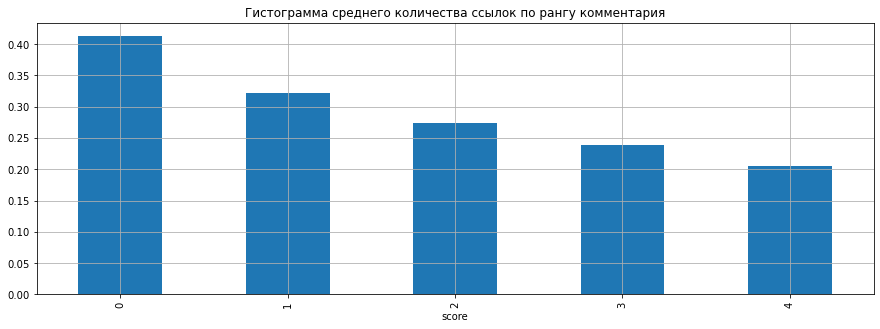

In [70]:
# сгруппируем таблицу по 'score' со значениями количеств ссылок
df_score = df_train.groupby ('score')['num_url'].mean ()

# построим график
df_score.plot (kind = 'bar', y = 'num_url', style = 'o-', xlim = (0, 38), grid = True, figsize = (15, 5))

#подписи к графику
plt.title ('Гистограмма среднего количества ссылок по рангу комментария')
plt.show()

Видим, что чем больше количество комментариев в комментах, ранг коммента ниже

## Выбор и обучение модели

Попробовал такие модели как:

BERT - слишком тяжелая, не для моей машины

GPT-3 - не понравилось долгое обучение

XLNet - Не успел попробовать

DistilBert - меньше BERT и легче настраивается

Попробум обучить нашу модель DistilBertModel.

Загрузим саму модель (уже раее обученную), токенизатор и веса модели

In [71]:
model_class, tokenizer_class, pretrained_weights = (
    DistilBertModel,
    DistilBertTokenizer,
    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model_BERT = model_class.from_pretrained(pretrained_weights)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Если нам позволет железо, а оно позволяет, то обучим на CUDA

In [72]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [73]:
!nvidia-smi
torch.cuda.is_available()

Sun Mar 19 07:22:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:02:00.0  On |                  N/A |
| 30%   41C    P8    24W / 220W |   6083MiB /  8192MiB |     19%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

Вот как выглядит наша сеть

In [74]:
model_BERT

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0): TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(i

In [75]:
model_BERT.output_layer_norm = nn.Sequential(
    nn.LayerNorm(768),
    nn.BatchNorm1d(768)
)

In [77]:
torch.cuda.empty_cache()
gc.collect()

0

Сделаем свой Dataset

In [78]:
train_data = MyDataset('train')
test_data = MyDataset('test')

batch_size = 8

train_size = int(0.8 * len(train_data))
test_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, test_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=False)

Количество topics в train : 88107
Количество topics в test : 14004


In [79]:
# Зададим максимальную длину нашиз паддингов из комментов
max_len = 80

In [80]:
# Модель для получения эмбеддингов из текста
embeddingNetwork = model_BERT

In [81]:
# И модель классификации
classifierNetWork = My_Model(embeddingNetwork)
classifierNetWork.to(device)

My_Model(
  (embeddingLayer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_

In [82]:
loss_fn = custom_loss()

In [83]:
torch.cuda.empty_cache()
gc.collect()

0

In [84]:
optimizer = Adam(classifierNetWork.parameters(), lr=1e-4, betas=(0.9, 0.99)) #добавлено для оптимизации
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5) #добавлено для оптимизации

In [85]:
model, history = train(
    train_loader,
    val_loader,
    model = classifierNetWork,
    epochs = 8,
    batch_size = batch_size,
    optimizer = optimizer,
    sheduler = exp_lr_scheduler,
    criterion = loss_fn
)

epoch:   0%|                                              | 0/8 [00:00<?, ?it/s]

loss 1.6042399798250269


epoch:  12%|████▎                             | 1/8 [33:47<3:56:29, 2027.08s/it]


Epoch 001 train_loss: 1.6042     val_loss 2.0681 train_acc 0.2291 val_acc 0.2000
loss 1.5886874887164233


epoch:  25%|████████                        | 2/8 [1:08:01<3:24:19, 2043.21s/it]


Epoch 002 train_loss: 1.5887     val_loss 1.8982 train_acc 0.2466 val_acc 0.2000
loss 1.5868896495712803


epoch:  38%|████████████                    | 3/8 [1:42:17<2:50:45, 2049.03s/it]


Epoch 003 train_loss: 1.5869     val_loss 2.1407 train_acc 0.2499 val_acc 0.2000
loss 1.5875890023753532


epoch:  50%|████████████████                | 4/8 [2:16:36<2:16:51, 2052.98s/it]


Epoch 004 train_loss: 1.5876     val_loss 2.2741 train_acc 0.2480 val_acc 0.2000
loss 1.587589066762711


epoch:  62%|████████████████████            | 5/8 [2:50:59<1:42:49, 2056.49s/it]


Epoch 005 train_loss: 1.5876     val_loss 2.2237 train_acc 0.2474 val_acc 0.2000
loss 1.5841935418978301


epoch:  75%|████████████████████████        | 6/8 [3:25:19<1:08:35, 2057.83s/it]


Epoch 006 train_loss: 1.5842     val_loss 2.0452 train_acc 0.2528 val_acc 0.2000
loss 1.583597700951143


epoch:  88%|█████████████████████████████▊    | 7/8 [3:59:42<34:19, 2059.41s/it]


Epoch 007 train_loss: 1.5836     val_loss 2.2699 train_acc 0.2530 val_acc 0.2000
loss 1.5820636939899617


epoch: 100%|██████████████████████████████████| 8/8 [4:34:14<00:00, 2056.76s/it]


Epoch 008 train_loss: 1.5821     val_loss 2.4316 train_acc 0.2542 val_acc 0.2000
Best val Acc: 0.200000


In [86]:
torch.save(model.state_dict(), 'model_DistilBert.pth')

In [87]:
model.to(device)
model.load_state_dict(torch.load('model_DistilBert.pth', map_location=torch.device(device)))

<All keys matched successfully>

In [88]:
epoch, loss, val_loss, acc, val_acc = zip(*history)

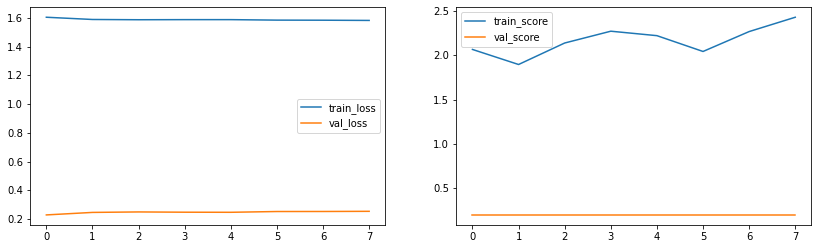

In [89]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].plot(epoch, loss, label='train_loss')
axes[0].plot(epoch, val_loss, label='val_loss')
axes[1].plot(epoch, acc, label='train_score')
axes[1].plot(epoch, val_acc, label='val_score')
for i in [0,1]:
    axes[i].legend()

In [ ]:
test_accuracy, test_loss = evaluate(model, test_loader, loss_fn)
test_accuracy, test_loss

## Вывод

Видимо неверно выбрал функцию лосса. Надо работать в данном напрвлении дальше